In [3]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

import sys
from importlib import reload

import crispr_assembler as ca
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
np.linspace(0,10,2)

array([ 0., 10.])

In [3]:

sys.path.append("../crispr_assembler/crispr_assembler/src/utils/")

In [5]:
reads, quals = ca.read_fastq("../data/cdif_11_12_bc/assembled/-merged.assembled.fastq")

In [6]:
import regex as re

In [7]:
m1s = 'AAGCAGTGGTATCAACGCAGAGT'

In [8]:
p = re.compile('(?:'  + m1s + '){e<=2}')
p_cut = re.compile('(?:' + m1s[-11:] + '){e<=2}')
p_rc = re.compile('(?:' + ca.rc(m1s, r = 1) + '){e<=2}')
p_rc_cut = re.compile('(?:' + ca.rc(m1s[-11:], r = 1) + '){e<=2}')

In [10]:
from tqdm import tqdm_notebook

In [9]:
read = reads[2]

In [10]:
def extract_read_bc(read, pattern, search_rc=0):
    coords = [x.span() for x in re.finditer(pattern, read)]
    rc = 0
    if len(coords) == 0 and search_rc:
        read = ca.rc(read, r=1)
        coords = [x.span() for x in re.finditer(pattern, read)]
        rc = 1
    if len(coords) != 0:        
        bc_start = [x.span() for x in re.finditer(pattern, read)][0][1]
        bc_end = bc_start + 10

        bc = read[bc_start: bc_end]
        read_cut = read[bc_end:]

        return bc, read_cut, read, rc
    else:
        return -1, -1, -1, -1

In [13]:
reads_clusterized = {}

In [14]:
len(reads)

3486683

In [15]:
p_cut

regex.Regex('(?:CAACGCAGAGT){e<=2}', flags=regex.V0)

In [16]:
extract_read_bc(reads[1], p_cut, search_rc=1)

('ATGTCGTGCC',
 'CCACTTAGTTAATATAAAACTTTATATTTCGTCGCACGGATTCGTGCGAAGGGTTGGATTTACATACCACTTAGT',
 'ACATCTCGAAGCAGTGGTATCAACGCAGAGTATGTCGTGCCCCACTTAGTTAATATAAAACTTTATATTTCGTCGCACGGATTCGTGCGAAGGGTTGGATTTACATACCACTTAGT',
 1)

In [48]:
from multiprocessing import Pool

In [49]:
p = Pool(6)

Process ForkPoolWorker-29:
Process ForkPoolWorker-28:
Process ForkPoolWorker-26:
Process ForkPoolWorker-25:
Process ForkPoolWorker-24:
Process ForkPoolWorker-27:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._ar

In [11]:
def process_batch(batch):
    reads_clusterized = {}
    for r in tqdm_notebook(batch):
        bc, r_cut, r, inv = extract_read_bc(r, p_cut)
        if bc != -1:
            if bc in reads_clusterized:
                reads_clusterized[bc].append(r_cut)
                #print (f'mrgd {bc}')
            else:
                reads_clusterized[bc] = [r_cut]
                
    return reads_clusterized

In [27]:
def get_splits(max_idx, n_splits):
    splits = []
    spl = np.linspace(0, max_idx, n_splits, dtype=int)
    for i, j in zip(spl[:-1], spl[1:]):
        splits.append((i, j))
        
    return splits

In [34]:
reads_batches = [reads[idxs[0]: idxs[1]] for idxs in get_splits(len(reads), 6)]

In [39]:
[len(x) for x in reads_batches]

[697336, 697337, 697336, 697337, 697337]

In [14]:
reads_clusterized = process_batch(reads)

A Jupyter Widget

In [54]:
clusters_array = p.map(process_batch, reads_batches)

KeyboardInterrupt: 

In [30]:
p.close()

In [35]:
del read

In [31]:
%whos

Variable            Type        Data/Info
-----------------------------------------
Pool                method      <bound method BaseContext<...>bject at 0x7ff8727c93c8>>
ca                  module      <module 'crispr_assembler<...>r_assembler/__init__.py'>
extract_read_bc     function    <function extract_read_bc at 0x7ff83d059d08>
m1s                 str         AAGCAGTGGTATCAACGCAGAGT
np                  module      <module 'numpy' from '/ho<...>kages/numpy/__init__.py'>
p                   Pool        <multiprocessing.pool.Poo<...>object at 0x7ff7622794a8>
p_cut               Pattern     regex.Regex('(?:CAACGCAGA<...>){e<=2}', flags=regex.V0)
p_rc                Pattern     regex.Regex('(?:ACTCTGCGT<...>){e<=2}', flags=regex.V0)
p_rc_cut            Pattern     regex.Regex('(?:ACTCTGCGT<...>){e<=2}', flags=regex.V0)
plt                 module      <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
process_batch       function    <function process_batch at 0x7ff7ca1fc6a8>
qual

In [18]:
len(reads_clusterized)

507007

In [15]:
import pickle

In [16]:
pickle.dump(reads_clusterized, open("../data/cdif_11_12_bc/reads_clustred_bc_fwd", 'wb'))

In [22]:
lens = []
for k,v in reads_clusterized.items():
    lens = len(v)

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <a list of 10 Patch objects>)

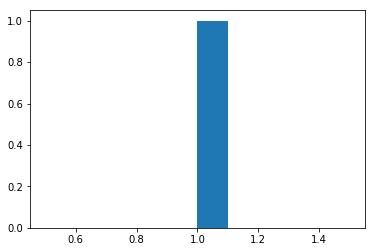

In [23]:
plt.hist(lens)

In [30]:
ca.rc("ATTTACATTCCATATAGTTAATCTAAAAC", r=1)

'GTTTTAGATTAACTATATGGAATGTAAAT'

In [33]:
ca.rc(ca.redundant.rc, r=1)

'MTTTACATWCCAYWTAGTTAATMTAAAAC'

In [32]:
ca.repeat_to_re_pattern(ca.rc("ATTTACATTCCATATAGTTAATCTAAAAC", r=1))

'(GTTTTAGATTAACTATATGGAATGTAAAT){e<=2}'

In [34]:
ca.find(ca.rc(ca.redundant.rc, r=1), reads[2])

[(89, 120)]

In [50]:
ca.split_read(reads[0], reads[0], ca.redundant.reverse_complementary())

(['ACCACATCAAAGTTATCTTTAATAGAAGTTATCTC', 'NTTGGCACTATTATTTGCACAGGATAAGGCTGAT'],
 ['ACCACATCAAAGTTATCTTTAATAGAAGTTATCTC', 'NTTGGCACTATTATTTGCACAGGATAAGGCTGAT'])

In [43]:
import importlib

ca = importlib.reload(ca)

In [44]:
ca.redundant.rc

'GTTTTAKATTAACTAWRTGGWATGTAAAK'

In [49]:
ca.redundant.reverse_complementary().rc

'MTTTACATWCCAYWTAGTTAATMTAAAAC'

In [17]:
reads_splits = {}

for k, v in tqdm_notebook(reads_clusterized.items()):
    reads_splits[k] = ca.split_read(v[0], 'Z' * len(v), ca.redundant.reverse_complementary())

A Jupyter Widget

In [28]:
sample_from_dict(reads_clusterized)[0]

['CCATTTAGTTAATATAAAACACCACATCAAAGTTATCTTTAATAGAAGTTATCTCCTATTTACATTCCATATAGTTAATATAAAACNTTGGCACTATTATTTGCACAGGATAAGGCTGATGGATTTACATTCCATATAGTCGAGATNT']

In [35]:
ca.split_read(sample_from_dict(reads_clusterized)[2][0], 'Z' * len(v), ca.redundant.reverse_complementary())

([-1, -1], [-1, -1])

In [20]:
len(reads_splits)

507007

In [21]:
def sample_from_dict(d):
    return [x for x in d.values()][:10]

In [36]:
pickle.dump(reads_splits, open("../data/cdif_11_12_bc/reads_splits_bc_fwd", 'wb'))

In [24]:
reads_splits_f = {}

for k, v in tqdm_notebook(reads_splits.items()):
    if not -1 in v[1] and not -1 in v[0] and len(v[0][0]) > 0:
        reads_splits_f[k] = v[0]

A Jupyter Widget

In [12]:
import pickle

In [17]:
reads_splits = pickle.load(open("../data/cdif_11_12_bc/reads_splits_bc_fwd", 'rb'))

In [37]:
len(reads_splits_f)

262730

In [21]:
with open("../data/cdif_11_12/out/restored/Cdif-planeA_S6_L001_R1_001_arrays_num") as f:
    arrs = [[int(y) for y in x[:-1].split(', ')] for x in  f.readlines()]

In [22]:
cl_to_ind = ca.dict_from_csv("../data/cdif_11_12/out/restored/Cdif-planeA_S6_L001_R1_001_cl_to_ind")

In [38]:
gr_ans = ca.list_to_gr(arrs, 500)

In [39]:
gr_bc = np.zeros_like(gr_ans)

In [26]:
reads_splits_f['CNAANGTTGT']

['ACCACATCAAAGTTATCTTTAATAGAAGTTATCTC', 'NTTGGCACTATTATTTGCACAGGATAAGGCTGAT']

In [30]:
ca.find_closest(cl_to_ind, ca.rc('ACCACATCAAAGTTATCTTTAATAGAAGTTATCTC', r=1))

(2, 'AGGAGATAACTTCTATTAAAGATAACTTTGATGTGGT')

In [33]:
def find_closest_rc(d, sp, t=5):
    answ_1 = ca.find_closest(d, sp)
    answ_2 = ca.find_closest(d, ca.rc(sp, r=1))
    if answ_1[0] < answ_2[0] and answ_1[0] <= t:
        return answ_1
    elif answ_2[0] <= answ_1[0] and answ_2[0] <= t:
        return answ_2
    else:
        return [-1,-1]

In [43]:
for k, v in tqdm_notebook(reads_splits_f.items()):
    ind_1 = find_closest_rc(cl_to_ind, v[0])
    ind_2 = find_closest_rc(cl_to_ind, v[1])
     
    if ind_1[0] != -1 and ind_2[0] != -1:
        #print('good')
        gr_bc[int(cl_to_ind[ind_2[1]]),
              int(cl_to_ind[ind_1[1]])] += 1

A Jupyter Widget

In [86]:
cl_to_ind[ca.find_closest(cl_to_ind, v[0])[1]]

'214'

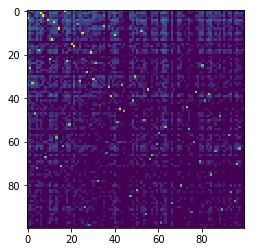

In [45]:
plt.imshow(np.log(gr_bc[:100,:100] + 1))

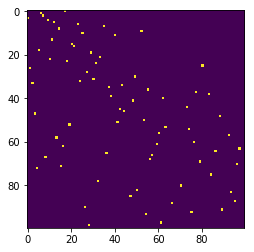

In [44]:
plt.imshow(np.log(gr_ans[:100,:100] + 1))

In [56]:
bcws = []
for arr in arrs:
    bc_w = []
    for a, b in zip(arr, arr[1:]):
        bc_w.append(gr_bc[a,b])
    bcws.append(bc_w)

In [57]:
bcws

[[701.0,
  1022.0,
  9786.0,
  15583.0,
  1987.0,
  88.0,
  62.0,
  765.0,
  4163.0,
  3255.0,
  3050.0,
  2629.0,
  676.0,
  27.0],
 [104.0,
  74.0,
  242.0,
  652.0,
  3528.0,
  12099.0,
  1519.0,
  3481.0,
  2462.0,
  7993.0,
  1019.0,
  10.0],
 [309.0,
  402.0,
  292.0,
  3709.0,
  982.0,
  9.0,
  37.0,
  23.0,
  740.0,
  9309.0,
  1370.0,
  1539.0,
  5653.0],
 [63.0,
  1225.0,
  2525.0,
  1477.0,
  1138.0,
  148.0,
  979.0,
  428.0,
  266.0,
  938.0,
  226.0,
  48.0,
  1101.0,
  6128.0,
  8702.0,
  2.0,
  1089.0,
  9665.0,
  0.0,
  4818.0,
  11200.0,
  3286.0,
  2816.0,
  1850.0,
  12.0,
  1.0,
  0.0],
 [18.0, 1020.0, 10367.0],
 [11.0, 296.0, 103.0, 249.0, 223.0, 1816.0, 6442.0],
 [409.0,
  271.0,
  114.0,
  602.0,
  375.0,
  71.0,
  245.0,
  201.0,
  5145.0,
  2426.0,
  732.0,
  579.0,
  1183.0,
  196.0,
  56.0,
  32.0,
  182.0,
  3153.0,
  6011.0,
  895.0,
  868.0,
  1230.0,
  121.0,
  0.0],
 [11.0, 408.0, 2082.0],
 [136.0, 8276.0, 142.0],
 [3.0, 8.0, 90.0, 3406.0],
 [389.0, 108

In [54]:
lens = []
for v  in reads_splits.values():
    lens.append(len(v))

(array([     0.,      0.,      0.,      0.,      0., 507007.,      0.,
             0.,      0.,      0.]),
 array([1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5]),
 <a list of 10 Patch objects>)

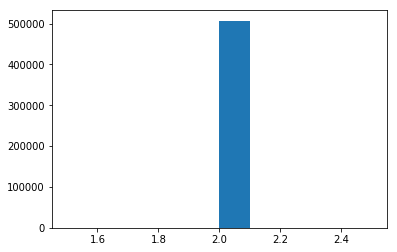

In [55]:
plt.hist(lens)